Created some code to make the mnist-data into a segmentation problem. This was done by setting an semi-arbitrary threshold for the pixel intensity that we want to classify as belonging to the handwritten digit or not.

In [43]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
import scipy
######################################################################################################
# This code loads the data

# Define number of classes
# 0-9 and background-class
num_classes = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.array(x_train)
x_test = np.array(x_test)
n_train = x_train.shape[0]
n_test = x_test.shape[0]

######################################################################################################
# This code upscales images to fit UNet downsampling (28*28 -> 32*32)
new_size = 32
temp = np.zeros((n_train, 32, 32))
# Factor to upscale with
zoom = 32/28

for i in range(n_train):
    if i % 10000 == 0:
        print("Upscale train: " + str(i))
    x = x_train[i]
    temp[i] = scipy.ndimage.zoom(x, zoom=zoom, output=None, order=3, mode='constant', cval=0.0, prefilter=True)

x_train = temp

temp = np.zeros((n_test, 32, 32))
# Make data fit UNet by upscaling 28*28 -> 32*32
for i in range(n_test):
    if i % 10000 == 0:
        print("Upscale test: " + str(i))
    x = x_test[i]
    temp[i] = scipy.ndimage.zoom(x, zoom=zoom, output=None, order=3, mode='constant', cval=0.0, prefilter=True)

x_test = temp

######################################################################################################
# This code creates a mask
# Threshold is what intensity value we use to label pixel as beloning to letter or not
threshold = 80
# The segmented data is now the ground truth instead of just the label
seg_train_data = np.zeros(x_train.shape)
seg_test_data = np.zeros(x_test.shape)

for i in range(n_train):
    if i % 10000 == 0:
        print("Create mask train: " + str(i))
    # Get indices of where number is larger than threshold
    ind = np.where(x_train[i] > threshold)
    # Make a empty matrix to fill with the label value at the index locations
    temp = np.zeros(x_train[i].shape)
    temp[ind] = 1
    seg_train_data[i] = temp

# Do the same for the test data
for i in range(n_test):
    if i % 10000 == 0:
        print("Create mask test: " + str(i))
    ind = np.where(x_test[i] > threshold)
    
    temp = np.zeros(x_test[i].shape)
    temp[ind] = 1
    seg_test_data[i] = temp

# Normalize data
x_train = np.divide(x_train, 255)
x_test = np.divide(x_test, 255)

# Create one hot encoding
one_hot_enc_seg_train = np.zeros([n_train, new_size, new_size, num_classes])
one_hot_enc_seg_test = np.zeros([n_test, new_size, new_size, num_classes])

# The shape of the ouput tensor of UNet
pic_shape = list(x_train[i].shape) + [num_classes]

for i in range(n_train):
    if i % 10000 == 0:
        print("OHE train: " + str(i))
    # Make a empty matrix to fill with the label value at the index locations
    temp = np.zeros(pic_shape)
    label = y_train[i]
    temp[:,:,(label)] = seg_train_data[i]
    one_hot_enc_seg_train[i, :, :, :] = temp

for i in range(n_test):
    if i % 10000 == 0:
        print("OHE test: " + str(i))
    # Make a empty matrix to fill with the label value at the index locations
    temp = np.zeros(pic_shape)
    label = y_test[i]
    temp[:,:,(label)] = seg_test_data[i]
    one_hot_enc_seg_test[i, :, :, :] = temp

Upscale train: 0
Upscale train: 10000
Upscale train: 20000
Upscale train: 30000
Upscale train: 40000
Upscale train: 50000
Upscale test: 0
Create mask train: 0
Create mask train: 10000
Create mask train: 20000
Create mask train: 30000
Create mask train: 40000
Create mask train: 50000
Create mask test: 0
OHE train: 0
OHE train: 10000
OHE train: 20000
OHE train: 30000
OHE train: 40000
OHE train: 50000
OHE test: 0


Show that segmentation worked

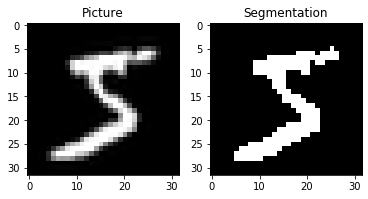

In [44]:
i = 0
plt.subplot(121)
plt.imshow(x_train[i], cmap='gray')
plt.title('Picture')
plt.subplot(122)
plt.imshow(seg_train_data[i], cmap='gray')
plt.title('Segmentation')
plt.show()

(32, 32, 10)
3


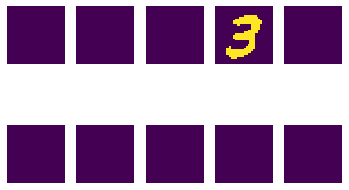

In [45]:
# Visualise one hot encoding
for i in range(num_classes):
    # Really hacky solution with i>4 being false aka 0 first then being true aka 1 and using that as index
    plt.subplot2grid((2,5), (i>4, i%5))
    plt.imshow(one_hot_enc_seg_train[7, :, :, i])
    plt.axis("off")

print(one_hot_enc_seg_train[7, :, :, :].shape)
print(y_train[7])

The artificially segmented mnist-data will serve as data to get UNet to work.

In [6]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

def unet_mnist(pretrained_weights = None, input_size = (28, 28, 1)):
    inputs = Input(input_size)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(drop2)
    
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    drop3 = Dropout(0.5)(conv3)
    
    up4 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop3))
    merge4 = concatenate([drop2, up4], axis = 3)
    conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge4)
    conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    
    up5 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv4))
    merge5 = concatenate([conv1, up5], axis = 3)
    conv5 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge5)
    conv5 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    
    conv6 = Conv2D(num_classes, 1, activation = 'sigmoid', padding = 'same', kernel_initializer = 'he_normal')(conv5)

    model = Model(input = inputs, output = conv6)
    
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

my_model = unet_mnist()
my_model.summary()



/Users/linuslagergren/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
W0919 09:18:01.970280 4525954496 deprecation_wrapper.py:119] From /Users/linuslagergren/anaconda/lib/python3.6/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0919 09:18:01.981379 4525954496 deprecation_wrapper.py:119] From /Users/linuslagergren/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3576: The name tf.log is deprecated. Please use tf.math.log instead.



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 28, 28, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 28, 28, 32)   9248        conv2d_13[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 14, 14, 32)   0           conv2d_14[0][0]                  
____________________________________________________________________________________________

In [62]:
# Train model
samples_used = 60000
x_train = x_train.reshape((60000, 28, 28, 1))
x_train1 = x_train[0:samples_used, :, :, :]
y_train1 = one_hot_enc_seg_train[0:samples_used, :, :, :]
# Returns an object with accuracy and loss
history = my_model.fit(x=x_train1, y=y_train1, batch_size=None, epochs=1, verbose=1, callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None, validation_freq=1)


Epoch 1/2
60000/60000 [==============================] - 778s 13ms/step - loss: 0.2864 - acc: 0.4136
Epoch 2/2
60000/60000 [==============================] - 723s 12ms/step - loss: 0.2319 - acc: 0.3539


In [68]:
for x in history.history:
    print(x)
#plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
#plt.title('Model accuracy')
#plt.ylabel('Accuracy')
#plt.xlabel('Epoch')
#plt.legend(['Train', 'Test'], loc='upper left')

loss
acc


7


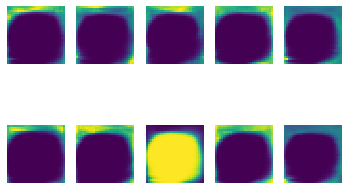

In [124]:
# Load weights of model
my_model.load_weights("my_model.h5")

# Make a prediction from the test set
ind = 0
x = x_test[ind].reshape((1,28,28,1))
yhat = my_model.predict(x)

# Visualise one hot encoding
for i in range(num_classes):
    # Really hacky solution with i>4 being false aka 0 first then being true aka 1 and using that as index
    plt.subplot2grid((2,5), (i>4, i%5))
    plt.imshow(yhat[0, :, :, i])
    plt.axis("off")

#print(np.max(yhat[0, :, :, :]))
print(y_test[ind])
#This does not seem like 95% accuracy as the training said

In [46]:
import numpy as np
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

def unet(pretrained_weights = None, input_size = (256, 256, 1)):
  inputs = Input(input_size)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)
  
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size = (2, 2))(conv2)
  
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size = (2, 2))(conv3)
  
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size = (2, 2))(drop4)
  
  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  drop5 = Dropout(0.5)(conv5)
  
  up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2, 2))(drop5))
  merge6 = concatenate([drop4, up6], axis = 3)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
  
  up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2, 2))(conv6))
  merge7 = concatenate([conv3, up7], axis = 3)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
  
  up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2, 2))(conv7))
  merge8 = concatenate([conv2, up8], axis = 3)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
  
  up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2, 2))(conv8))
  merge9 = concatenate([conv1, up9], axis = 3)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)# Is the 12 here the number of classes ?
  
  # Ja, tolvan var antalet klasser
  num_classes = 10
  conv9 = Conv2D(num_classes, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  
  # Not sure what the three lines below are doing
  reshape = Reshape((num_classes, input_size[0] * input_size[1]), input_shape = (num_classes, input_size[0], input_size[1]))(conv9)
  permute = Permute((2, 1))(reshape)
  activation = Activation('softmax')(permute)
  # Den här raden kod är ju om man vill få outputlagret till den form man önskar men det är nog smartare att reshapea labelsen
  #reshape = Reshape((num_classes, input_size[0], input_size[1]), input_shape = (num_classes, input_size[0]*input_size[1]))(activation)
  
  model = Model(input = inputs, output = activation)
  model.compile(optimizer = Adam(lr=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  if (pretrained_weights):
    model.load_weights(pretrained_weights)
  return model

In [48]:
my_unet = unet(input_size=(32, 32, 1))
my_unet.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_141 (Conv2D)             (None, 32, 32, 64)   640         input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_142 (Conv2D)             (None, 32, 32, 64)   36928       conv2d_141[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_33 (MaxPooling2D) (None, 16, 16, 64)   0           conv2d_142[0][0]                 
____________________________________________________________________________________________

/Users/linuslagergren/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`
